# Urban Flood Vulnerability Assessment - Colombo District, Sri Lanka

**Assignment 2 - Scientific Programming for Geospatial Sciences**

**Authors:** Surya Jamuna Rani Subramaniyan (S3664414) & Sachin Ravi (S3563545)

---

## Contents

0. **Setup & Data Download** - Automated data acquisition
1. **Data Loading** - Load real datasets (DEM, CHIRPS, Buildings)
2. **NumPy Array Operations** - Raster processing
3. **PyTorch Tensor Operations** - GPU-aware processing with performance comparison
4. **Vector Processing** - GeoPandas/Shapely operations (3+)
5. **Xarray Data Cubes** - Multi-temporal analysis
6. **Raster-Vector Integration** - Bidirectional operations
7. **Visualization** - Maps and dashboard

---

**Study Area:** Colombo District, Sri Lanka  
**Bounding Box:** 79.82E - 80.22E, 6.75N - 7.05N

## 0. Setup & Data Download

Run this section once to download all required datasets automatically.  
**No API keys required!**

In [1]:
# Core imports
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import torch
import matplotlib.pyplot as plt
import requests
import json
import gzip
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Our modules
import sys
sys.path.append('..')
from src import data_loading, raster_analysis, tensor_operations, vector_analysis, integration, visualization



In [2]:
# Study area configuration
COLOMBO_BBOX = {
    'west': 79.82,
    'east': 80.22,
    'south': 6.75,
    'north': 7.05
}

# Paths
DATA_DIR = Path('../data')
RAW_DIR = DATA_DIR / 'raw'
PROCESSED_DIR = DATA_DIR / 'processed'
OUTPUT_DIR = Path('../outputs')

# Create directories
for d in [RAW_DIR / 'chirps', RAW_DIR / 'srtm', RAW_DIR / 'admin', 
          RAW_DIR / 'buildings', PROCESSED_DIR, OUTPUT_DIR]:
    d.mkdir(parents=True, exist_ok=True)



In [3]:
# Helper function for downloads
def download_file(url, output_path, timeout=120):
    """Download a file with progress indication."""
    if output_path.exists():
        print(f"  Already exists: {output_path.name}")
        return True
    
    try:
        print(f"  Downloading: {output_path.name}...")
        response = requests.get(url, stream=True, timeout=timeout)
        response.raise_for_status()
        
        total_size = int(response.headers.get('content-length', 0))
        downloaded = 0
        
        with open(output_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
                downloaded += len(chunk)
                if total_size > 0:
                    pct = (downloaded / total_size) * 100
                    print(f"\r  Downloading: {output_path.name}... {pct:.1f}%", end='', flush=True)
        
        print(f"\n  Saved: {output_path.name}")
        return True
    except Exception as e:
        print(f"  Error: {e}")
        return False

### 0.1 Download SRTM DEM from AWS

In [4]:
# Download SRTM tiles from AWS Open Data
print("Downloading SRTM DEM from AWS...")

# Get required tiles for Colombo
srtm_tiles = ['N06E079', 'N06E080', 'N07E079', 'N07E080']
base_url = "https://elevation-tiles-prod.s3.amazonaws.com/skadi"

dem_files = []
for tile in srtm_tiles:
    lat_dir = tile[:3]
    filename = f"{tile}.hgt.gz"
    url = f"{base_url}/{lat_dir}/{filename}"
    output_path = RAW_DIR / 'srtm' / filename
    
    if output_path.exists():
        print(f"  Already exists: {filename}")
        dem_files.append(output_path)
    else:
        if download_file(url, output_path, timeout=120):
            dem_files.append(output_path)

print(f"\nDownloaded {len(dem_files)} DEM tiles")

  Downloading: N06E079.hgt.gz...
  Downloading: N06E079.hgt.gz... 100.0%
  Saved: N06E079.hgt.gz
  Downloading: N06E080.hgt.gz...
  Downloading: N06E080.hgt.gz... 100.0%
  Saved: N06E080.hgt.gz
  Downloading: N07E079.hgt.gz...
  Downloading: N07E079.hgt.gz... 100.0%
  Saved: N07E079.hgt.gz
  Downloading: N07E080.hgt.gz...
  Downloading: N07E080.hgt.gz... 100.0%
  Saved: N07E080.hgt.gz

Downloaded 4 DEM tiles


### 0.2 Download CHIRPS 2025 Monthly Rainfall Data

In [5]:
# Download CHIRPS 2025 monthly rainfall data (~40 MB)
print("Downloading CHIRPS 2025 monthly rainfall data...")

chirps_url = "https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_monthly/netcdf/byYear/chirps-v2.0.2025.monthly.nc"
chirps_path = RAW_DIR / 'chirps' / 'chirps-v2.0.2025.monthly.nc'

download_file(chirps_url, chirps_path, timeout=300)

  Downloading: chirps-v2.0.2025.monthly.nc...
  Downloading: chirps-v2.0.2025.monthly.nc... 100.0%
  Saved: chirps-v2.0.2025.monthly.nc


True

In [6]:
# Download Colombo District boundary using Nominatim (returns standard GeoJSON)
print("Downloading admin boundaries from Nominatim...")

admin_path = RAW_DIR / 'admin' / 'colombo_boundary.json'

# Delete existing file if it might be the wrong format (Overpass JSON)
if admin_path.exists():
    # We'll check if it's valid GeoJSON by trying to read it, or just overwrite to be safe given the error history
    try:
        gpd.read_file(admin_path)
        print(f"  Valid file already exists: {admin_path.name}")
    except:
        print("  Found invalid/incompatible file. Re-downloading...")
        admin_path.unlink()

if not admin_path.exists():
    # Use Nominatim API for clean GeoJSON
    url = "https://nominatim.openstreetmap.org/search"
    headers = {'User-Agent': 'UrbanFloodAnalysis/1.0 (Student Project)'}
    params = {
        'q': 'Colombo District, Sri Lanka',
        'format': 'geojson',
        'polygon_geojson': 1,
        'limit': 1
    }
    
    try:
        response = requests.get(url, params=params, headers=headers, timeout=30)
        response.raise_for_status()
        data = response.json()
        
        if not data.get('features'):
            print("  Warning: No features found from Nominatim.")
        else:
            with open(admin_path, 'w') as f:
                json.dump(data, f)
            print(f"  Saved: {admin_path.name}")
            
    except Exception as e:
        print(f"  Error: {e}")

# Load into memory for masking
if admin_path.exists():
    try:
        district_mask = gpd.read_file(admin_path)
        # Ensure it's a Polygon/MultiPolygon
        district_mask = district_mask.dissolve()
        print(f"District mask loaded: {district_mask.geometry.type[0]}")
    except Exception as e:
        print(f"Failed to load district mask: {e}")

  Saved: colombo_boundary.json
District mask loaded: Polygon


In [7]:
# Download OSM buildings (this may take 5-10 minutes for urban areas)
print("Downloading building footprints from OpenStreetMap...")

buildings_path = RAW_DIR / 'buildings' / 'osm_buildings.json'

if not buildings_path.exists():
    overpass_url = "https://overpass-api.de/api/interpreter"
    
    # Query for buildings in Colombo BBox
    buildings_query = f"""
    [out:json][timeout:300];
    (
      way["building"]({COLOMBO_BBOX['south']},{COLOMBO_BBOX['west']},{COLOMBO_BBOX['north']},{COLOMBO_BBOX['east']});
    );
    out geom;
    """
    
    try:
        response = requests.post(overpass_url, data={'data': buildings_query}, timeout=600)
        response.raise_for_status()
        data = response.json()
        
        with open(buildings_path, 'w') as f:
            json.dump(data, f)
        
        print(f"  Saved: {buildings_path.name}")
        print(f"  Found {len(data.get('elements', []))} building elements")
    except Exception as e:
        print(f"  Error: {e}")
else:
    print(f"  Already exists: {buildings_path.name}")

  Saved: osm_buildings.json
  Found 379301 building elements


In [8]:
# Download OSM roads (real data)
print("Downloading road network from OpenStreetMap...")
roads_path = RAW_DIR / 'roads' / 'osm_roads.json'
roads = data_loading.download_osm_roads(
    COLOMBO_BBOX, roads_path,
    highway_types=['motorway','trunk','primary','secondary','tertiary','residential','service']
)
print(f"Saved: {roads_path.name} with {len(roads)} segments")


Requesting roads from Overpass API...
Downloaded raw roads to ..\data\raw\roads\osm_roads.json
Saved: osm_roads.json with 37555 segments


### 0.5 Preview Buildings on Map

In [9]:
# Load and Clip OSM Buildings
print("Loading OSM Buildings...")
osm_buildings_file = RAW_DIR / 'buildings' / 'osm_buildings.json'

if osm_buildings_file.exists():
    buildings = data_loading.load_osm_buildings(osm_buildings_file)
    
    # Clip to District (Masking requirement)
    # Check if district_mask is available (defined in earlier cell)
    if 'district_mask' in locals():
        try:
            print("Clipping buildings to district boundary...")
            buildings = vector_analysis.clip_vectors_to_boundary(buildings, district_mask)
        except Exception as e:
            print(f"Clipping failed: {e}")
    
    print(f"Loaded {len(buildings)} buildings")
else:
    print("OSM Buildings file not found. Please run Section 0.4.")

Loading OSM Buildings...
Clipping buildings to district boundary...
Loaded 231557 buildings


### 0.5 Data Status Check

In [10]:
# Check what data we have
print("DATA STATUS")
print("=" * 50)

# DEM
dem_files_found = list((RAW_DIR / 'srtm').glob('*.tif')) + list((RAW_DIR / 'srtm').glob('*.zip'))
print(f"SRTM Data:      Found" if dem_files_found else "SRTM Data:      Not found")

# Admin boundaries
admin_files = list((RAW_DIR / 'admin').glob('*.json'))
print(f"Admin boundary: Found" if admin_files else "Admin boundary: Not found")

# CHIRPS
chirps_files = list((RAW_DIR / 'chirps').glob('*.nc'))
print(f"CHIRPS data:    Found ({chirps_files[0].name})" if chirps_files else "CHIRPS data:    Not found")

# Buildings
building_files = list((RAW_DIR / 'buildings').glob('*.json'))
print(f"Buildings:      Found" if building_files else "Buildings:      Not found")

print("=" * 50)

DATA STATUS
SRTM Data:      Not found
Admin boundary: Found
CHIRPS data:    Found (chirps-v2.0.2025.monthly.nc)
Buildings:      Found


---

## 1. Data Loading

Load the real datasets for analysis.

In [11]:
# Ensure District Mask is Loaded (Resilience Check)
# This ensures the mask is available even if Section 0 was skipped
if 'district_mask' not in locals():
    admin_path = RAW_DIR / 'admin' / 'colombo_boundary.json'
    if admin_path.exists():
        try:
            print("Loading district mask from disk...")
            district_mask = gpd.read_file(admin_path).dissolve()
            print("District mask loaded successfully.")
        except Exception as e:
            print(f"Error loading district mask: {e}")
    else:
        print("Warning: District boundary file not found. Visualizations may not be masked.")
else:
    print("District mask is already loaded.")

District mask is already loaded.


Download complete.
Extracting SRTM...
Extraction complete.
Elevation data loaded and masked: (1, 288, 217)


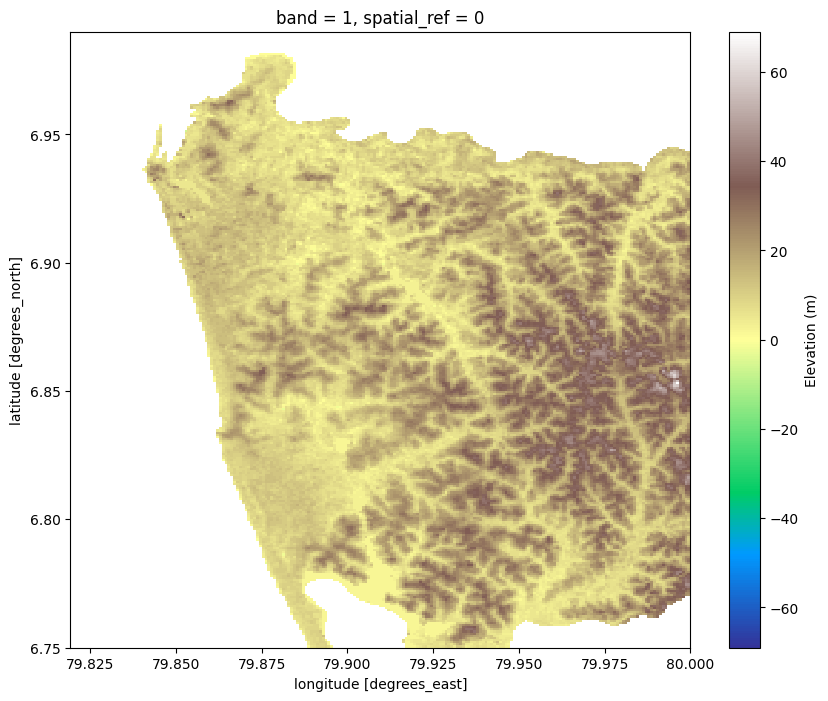

In [12]:
# Mask Elevation with District Boundary
elevation = data_loading.download_srtm(COLOMBO_BBOX, cache_dir=RAW_DIR / 'srtm')

# Apply Mask
elevation = raster_analysis.mask_raster_with_vector(elevation, district_mask)

print(f"Elevation data loaded and masked: {elevation.shape}")
elevation.plot(cmap='terrain', figsize=(10, 8), cbar_kwargs={'label': 'Elevation (m)'})

In [13]:
# Load CHIRPS 2025 rainfall data and clip to study area
print("Loading CHIRPS 2025 monthly rainfall data...")

chirps_file = RAW_DIR / 'chirps' / 'chirps-v2.0.2025.monthly.nc'

if chirps_file.exists():
    # Load full dataset
    ds = xr.open_dataset(chirps_file)
    
    # Get the precipitation variable and clip to BBOX first
    # Slice latitude (handle both ascending and descending cases)
    rainfall_cube = ds['precip'].sel(
        latitude=slice(COLOMBO_BBOX['south'], COLOMBO_BBOX['north']),
        longitude=slice(COLOMBO_BBOX['west'], COLOMBO_BBOX['east'])
    )
    if rainfall_cube.size == 0:
       rainfall_cube = ds['precip'].sel(
          latitude=slice(COLOMBO_BBOX['north'], COLOMBO_BBOX['south']),
          longitude=slice(COLOMBO_BBOX['west'], COLOMBO_BBOX['east'])
       )

        # Assign CRS explicitely before masking (Critical Fix)
    rainfall_cube.rio.write_crs("EPSG:4326", inplace=True)

    # Apply District Mask
    try:
        rainfall_cube = raster_analysis.mask_raster_with_vector(rainfall_cube, district_mask)
        print(f"Rainfall data loaded and masked: {rainfall_cube.shape}")
    except Exception as e:
        print(f"Warning: Masking failed ({e}), using rectangular clip")
    
else:
    print("CHIRPS file not found")

Loading CHIRPS 2025 monthly rainfall data...
Rainfall data loaded and masked: (12, 5, 8)


In [14]:
# Load and Clip OSM Buildings
print("Loading OSM Buildings...")
osm_buildings_file = RAW_DIR / 'buildings' / 'osm_buildings.json'

if osm_buildings_file.exists():
    buildings = data_loading.load_osm_buildings(osm_buildings_file)
    
    # Clip to District (Masking requirement)
    # Check if district_mask is available (defined in earlier cell)
    if 'district_mask' in locals():
        try:
            print("Clipping buildings to district boundary...")
            buildings = vector_analysis.clip_vectors_to_boundary(buildings, district_mask)
        except Exception as e:
            print(f"Clipping failed: {e}")
    
    print(f"Loaded {len(buildings)} buildings")
else:
    print("OSM Buildings file not found. Please run Section 0.4.")

Loading OSM Buildings...
Clipping buildings to district boundary...
Loaded 231557 buildings


In [15]:
# Download Real Admin Boundaries (Level 9 - Wards) & Parse Resiliently
from shapely.geometry import LineString, Polygon, MultiPolygon
from shapely.ops import linemerge, unary_union
import warnings

print("Downloading Admin Level 9 Wards and parsing geometry...")

ds_path = RAW_DIR / 'admin' / 'colombo_wards.json'
admin_boundaries = gpd.GeoDataFrame() # Initialize as empty

def parse_overpass_relation_to_poly(element):
    try:
        segments = []
        for member in element.get('members', []):
            if member['type'] == 'way' and 'geometry' in member:
                coords = [(pt['lon'], pt['lat']) for pt in member['geometry']]
                if len(coords) >= 2:
                    segments.append(LineString(coords))
        
        if not segments:
            return None
        merged = linemerge(segments)
        if merged.is_closed and not merged.is_empty:
             return Polygon(merged)
        elif hasattr(merged, 'geoms'):
             from shapely.ops import polygonize
             polys = list(polygonize(merged))
             if len(polys) == 1:
                 return polys[0]
             elif len(polys) > 1:
                 return MultiPolygon(polys)
        return None
    except:
        return None

# Ensure directory exists
ds_path.parent.mkdir(parents=True, exist_ok=True)

# Download/Parse
try:
    # Try loading existing first
    if ds_path.exists():
        try:
            print(f"  Attempting to load existing file: {ds_path.name}")
            admin_boundaries = gpd.read_file(ds_path)
            if not admin_boundaries.empty:
                print(f"  Loaded {len(admin_boundaries)} wards from disk.")
                # Ensure ds_id exists
                if 'ds_id' not in admin_boundaries.columns:
                     admin_boundaries['ds_id'] = [f"W{i:02d}" for i in range(len(admin_boundaries))]
        except Exception as e:
            print(f"  Error reading existing file: {e}")
            admin_boundaries = gpd.GeoDataFrame() # Reset on failure

    # If empty or not exists, DOWNLOAD
    if admin_boundaries.empty:
        print("  Downloading from Overpass API...")
        overpass_url = "https://overpass-api.de/api/interpreter"
        ds_query = f'''
        [out:json][timeout:180];
        (
          relation["admin_level"="9"]({COLOMBO_BBOX['south']},{COLOMBO_BBOX['west']},{COLOMBO_BBOX['north']},{COLOMBO_BBOX['east']});
        );
        out geom;
        '''
        response = requests.post(overpass_url, data={'data': ds_query}, timeout=300)
        response.raise_for_status()
        raw_data = response.json()
        
        features = []
        for el in raw_data.get('elements', []):
            if el['type'] == 'relation':
                geom = parse_overpass_relation_to_poly(el)
                if geom:
                    tags = el.get('tags', {})
                    feat = tags.copy()
                    feat['geometry'] = geom
                    feat['id'] = el['id']
                    features.append(feat)
        
        if features:
            admin_boundaries = gpd.GeoDataFrame(features, crs="EPSG:4326")
            if 'ds_id' not in admin_boundaries.columns:
                admin_boundaries['ds_id'] = [f"W{i:02d}" for i in range(len(admin_boundaries))]
            if 'ds_name' not in admin_boundaries.columns:
                admin_boundaries['ds_name'] = admin_boundaries.get('name', 'Unknown')
            
            # Save
            admin_boundaries.to_file(ds_path, driver="GeoJSON")
            print(f"  Successfully saved {len(admin_boundaries)} Wards.")
        else:
            print("  Warning: No features found.")

except Exception as e:
    print(f"Error in admin data logic: {e}")

# Fallback
if admin_boundaries.empty:
     print("  Creating empty fallback.")
     admin_boundaries = gpd.GeoDataFrame(columns=['ds_id', 'ds_name', 'geometry'], crs="EPSG:4326")

# Final Checks
if 'ds_id' not in admin_boundaries.columns:
    admin_boundaries['ds_id'] = [f"W{i:02d}" for i in range(len(admin_boundaries))]
    
# Create Mask
if not admin_boundaries.empty:
    district_mask = gpd.GeoDataFrame({'geometry': [admin_boundaries.unary_union]}, crs=admin_boundaries.crs)
else:
    print("Warning: Admin empty. Visualizations compromised.")


  Successfully saved 37 Wards.


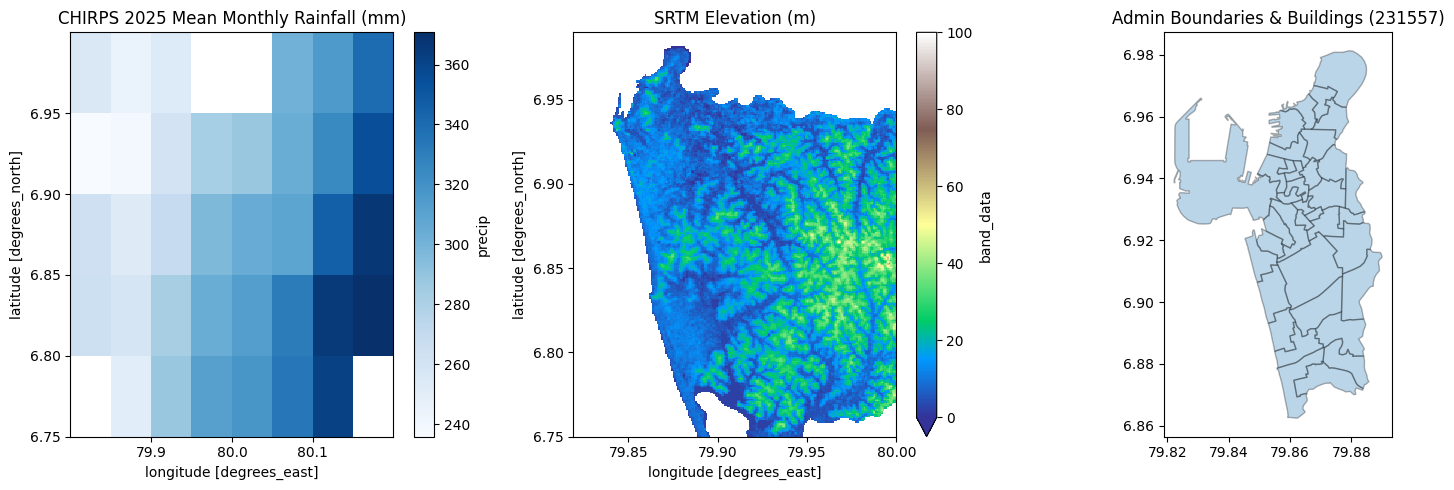

In [16]:
# Visualize the real data
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Rainfall
rainfall_cube.mean(dim='time').plot(ax=axes[0], cmap='Blues')
axes[0].set_title('CHIRPS 2025 Mean Monthly Rainfall (mm)')

# Elevation
elevation.plot(ax=axes[1], cmap='terrain', vmin=0, vmax=100)
axes[1].set_title('SRTM Elevation (m)')

# Admin and buildings
if not admin_boundaries.empty and 'geometry' in admin_boundaries.columns:
    admin_boundaries.plot(ax=axes[2], alpha=0.3, edgecolor='black')
else:
    print("Skipping Admin plot (Empty or No Geometry)")
if len(buildings) < 5000:
    buildings.plot(ax=axes[2], color='red', markersize=0.5, alpha=0.5)
axes[2].set_title(f'Admin Boundaries & Buildings ({len(buildings)})')

plt.tight_layout()
plt.show()

---

## 2. NumPy Array Operations

Array-based raster processing using real data.

In [17]:
# Get rainfall as numpy array
rainfall_np = rainfall_cube.values
print(f"Rainfall array shape: {rainfall_np.shape} (months, lat, lon)")

# Calculate max monthly rainfall for usage in operations
max_monthly_rainfall = rainfall_cube.max(dim='time')
print(f"Max monthly rainfall range: {float(max_monthly_rainfall.min()):.1f} - {float(max_monthly_rainfall.max()):.1f} mm")

Rainfall array shape: (12, 5, 8) (months, lat, lon)
Max monthly rainfall range: 524.1 - 709.2 mm


In [18]:
# Create high rainfall mask (>300mm/month threshold)
high_rainfall_mask = rainfall_np > 300
print(f"High rainfall events (>300mm/month): {high_rainfall_mask.sum()} grid-months")

High rainfall events (>300mm/month): 199 grid-months


Text(0.5, 1.0, 'Max Monthly Rainfall (Masked)')

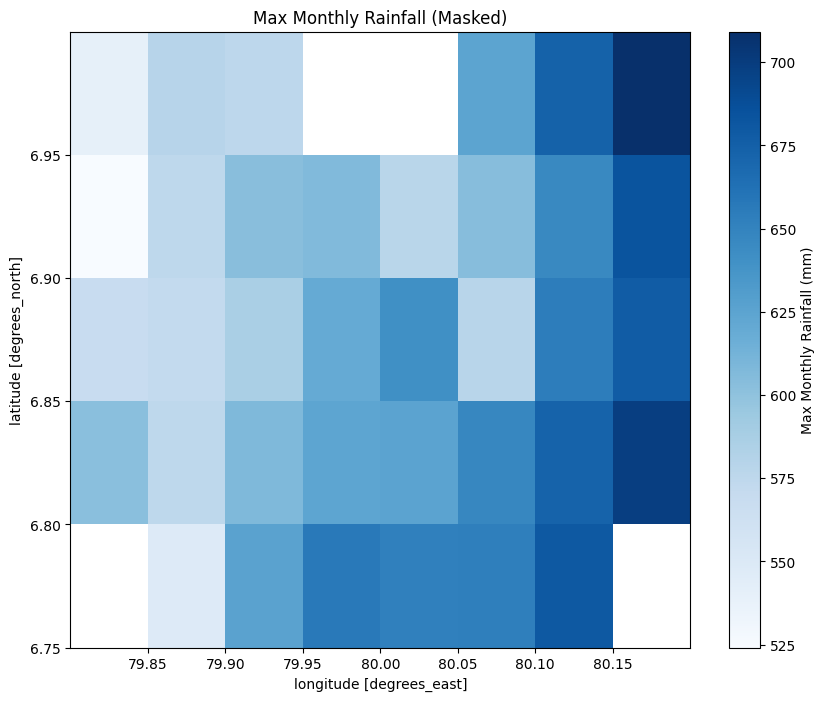

In [19]:
max_monthly_rainfall.plot(cmap='Blues', figsize=(10, 8), cbar_kwargs={'label': 'Max Monthly Rainfall (mm)'})
plt.title('Max Monthly Rainfall (Masked)')

In [20]:
# Calculate mean annual rainfall
mean_annual = np.nanmean(rainfall_np, axis=0) * 12  # Convert to annual
print(f"Estimated annual rainfall: {np.nanmean(mean_annual):.0f} mm/year")

Estimated annual rainfall: 3587 mm/year


In [21]:
# Normalize for vulnerability calculation
rainfall_norm = raster_analysis.normalize_array(max_monthly_rainfall, method='minmax')
elev_values = elevation.values
elev_values = np.nan_to_num(elev_values, nan=np.nanmean(elev_values))
elevation_norm = raster_analysis.normalize_array(elev_values, method='minmax')

print(f"Normalized rainfall range: {np.nanmin(rainfall_norm):.3f} - {np.nanmax(rainfall_norm):.3f}")
print(f"Normalized elevation range: {np.nanmin(elevation_norm):.3f} - {np.nanmax(elevation_norm):.3f}")

Normalized rainfall range: 0.000 - 1.000
Normalized elevation range: 0.000 - 1.000


---

## 3. PyTorch Tensor Operations

GPU-aware processing with performance comparison.

In [22]:
# Check GPU availability
tensor_operations.print_gpu_info()

Device Information
CUDA available: No
Apple MPS available: No
PyTorch version: 2.10.0+cpu


In [23]:
# Convert to tensor
rainfall_tensor = tensor_operations.numpy_to_tensor(max_monthly_rainfall, device='auto')
print(f"Tensor device: {rainfall_tensor.device}")
print(f"Tensor shape: {rainfall_tensor.shape}")

Tensor device: cpu
Tensor shape: torch.Size([5, 8])


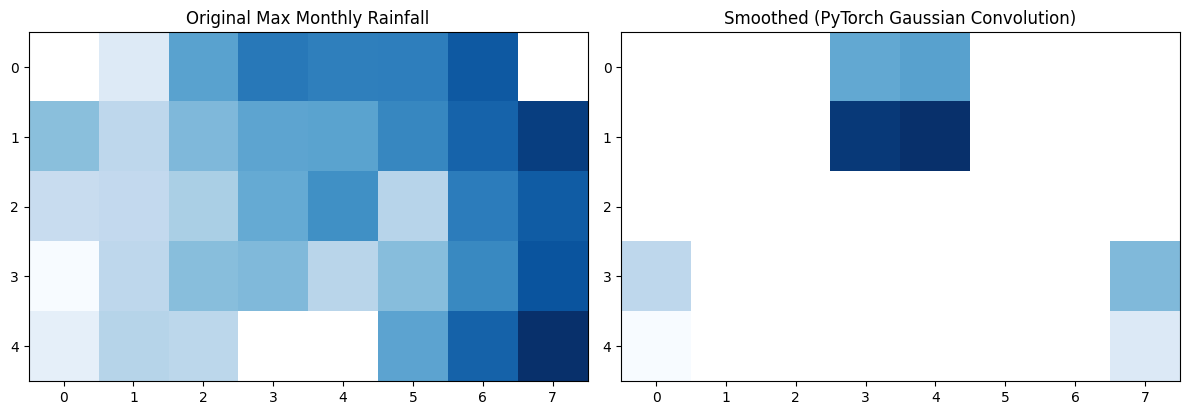

In [24]:
# Apply Gaussian convolution for spatial smoothing
smoothed_tensor = tensor_operations.apply_gaussian_convolution(
    rainfall_tensor, kernel_size=5, sigma=1.5
)

# Convert back to numpy for visualization
smoothed = tensor_operations.tensor_to_numpy(smoothed_tensor)

# Compare
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(max_monthly_rainfall, cmap='Blues', origin='upper')
axes[0].set_title('Original Max Monthly Rainfall')
axes[1].imshow(smoothed, cmap='Blues', origin='upper')
axes[1].set_title('Smoothed (PyTorch Gaussian Convolution)')
plt.tight_layout()
plt.show()

In [25]:
# PERFORMANCE COMPARISON: NumPy vs PyTorch
print("Running performance comparison...")
print("(Measuring Gaussian convolution speed)\n")

perf_results = tensor_operations.compare_numpy_vs_torch(
    max_monthly_rainfall, kernel_size=5, sigma=1.5, num_iterations=10
)

print("=" * 55)
print("        PERFORMANCE COMPARISON RESULTS")
print("=" * 55)
print(f"Array size:        {max_monthly_rainfall.shape}")
print(f"Operation:         5x5 Gaussian Convolution")
print(f"Iterations:        10")
print("")
print(f"NumPy (scipy):     {perf_results['numpy_time']*1000:.2f} ms +/- {perf_results['numpy_std']*1000:.2f} ms")
print(f"PyTorch ({perf_results['device']:6s}):  {perf_results['torch_time']*1000:.2f} ms +/- {perf_results['torch_std']*1000:.2f} ms")
print("")
print(f"Speedup:           {perf_results['speedup']:.2f}x")
print("=" * 55)

Running performance comparison...
(Measuring Gaussian convolution speed)

        PERFORMANCE COMPARISON RESULTS
Array size:        (5, 8)
Operation:         5x5 Gaussian Convolution
Iterations:        10

NumPy (scipy):     0.19 ms +/- 0.30 ms
PyTorch (cpu   ):  0.42 ms +/- 0.15 ms

Speedup:           0.46x


In [26]:
# Load OSM roads
roads_file = RAW_DIR / 'roads' / 'osm_roads.json'
roads = gpd.GeoDataFrame()
if roads_file.exists():
    roads = data_loading.load_osm_roads(roads_file, road_types=['motorway','trunk','primary','secondary','tertiary','residential','service'])
    print(f"Loaded roads: {len(roads)} segments")
else:
    print('Roads file not found; please run the download cell above.')


Loaded roads: 37086 segments


---

## 4. Vector Processing (GeoPandas/Shapely)

At least 3 vector operations as required.

In [27]:
# Spatial Join - assign DS to each building
buildings_joined = vector_analysis.spatial_join_buildings_to_admin(
    buildings, admin_boundaries, admin_id_col='ds_id'
)

print("OPERATION 1: Spatial Join")
print(f"   Buildings with DS assignment: {len(buildings_joined)}")
print(buildings_joined[['building_id', 'ds_id']].head())

OPERATION 1: Spatial Join
   Buildings with DS assignment: 231557
   building_id ds_id
0     52563172   W26
1     73142836   NaN
2     83981058   W24
3     83981239   NaN
5     98046408   W12


In [28]:
# Building Density Calculation
admin_with_density = vector_analysis.calculate_building_density(
    buildings, admin_boundaries, admin_id_col='ds_id'
)

print("OPERATION 2: Building Density Calculation")
print(admin_with_density[['ds_name', 'building_count', 'density_per_sqkm']])

OPERATION 2: Building Density Calculation
             ds_name  building_count  density_per_sqkm
0       AluthMawatha             177        277.062940
1        Bloemendhal             325        312.143267
2        Gintupitiya              21        105.293117
3       Lunupokurana             240        203.538421
4          Mahawatte            1344       1450.959188
5       Mattakkuliya            3844       1533.019446
6             Modera            1115       1675.671298
7          Grandpass            1265       1174.854118
8    Masangasweediya              22         81.878528
9          NewBazzar              13         25.366488
10         Aluthkade              78        183.828008
11       Kochchikade              62         78.463831
12              Fort             845        106.703227
13        Hunupitiya             228        297.221821
14          Maradana             132        503.839293
15         Suduwella             347        279.342338
16          Weekanda   

Total buffered road area: 2722.08 sqkm


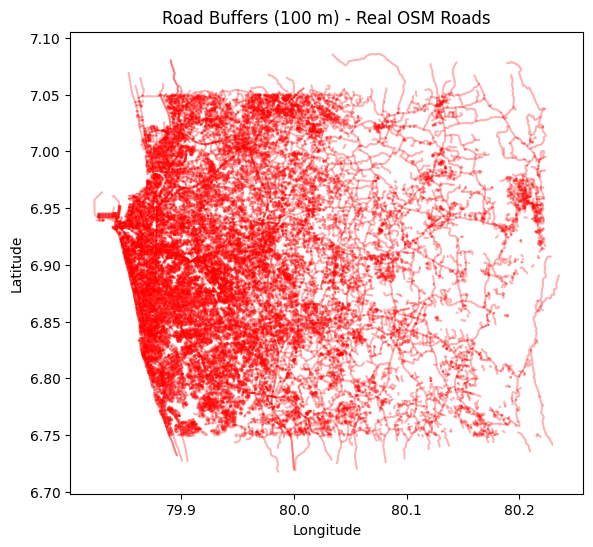

In [29]:
# Buffer analysis using real roads (100 m)
if roads.empty:
    print('Roads data unavailable; skipping road buffer analysis.')
else:
    roads_utm = roads.to_crs('EPSG:32644')
    road_buffers = roads_utm.buffer(100)  # 100 m buffer
    buffer_area = road_buffers.area.sum() / 1e6
    print(f'Total buffered road area: {buffer_area:.2f} sqkm')
    # Back to WGS84 for plotting
    road_buffers_wgs = road_buffers.to_crs('EPSG:4326')
    gpd.GeoSeries(road_buffers_wgs).plot(figsize=(8,6), color='red', alpha=0.3)
    plt.title('Road Buffers (100 m) - Real OSM Roads')
    plt.xlabel('Longitude'); plt.ylabel('Latitude')
    plt.show()


---

## 5. Xarray Data Cubes

Multi-temporal analysis with real CHIRPS 2025 data.

In [30]:
# Show data cube structure
print("Rainfall Data Cube Structure:")
print(rainfall_cube)

Rainfall Data Cube Structure:
<xarray.DataArray 'precip' (time: 12, latitude: 5, longitude: 8)>
array([[[       nan, 135.39539 , 157.41713 , 178.27838 , 193.43811 ,
         201.75034 , 223.26375 ,        nan],
        [176.67807 , 161.66776 , 160.04404 , 186.31367 , 201.75209 ,
         202.5744  , 219.41289 , 247.25534 ],
        [184.83278 , 162.71884 , 149.4261  , 195.72748 , 222.47763 ,
         244.66214 , 239.98714 , 253.54147 ],
        [ 88.74331 , 105.634125, 148.73476 , 181.3901  , 210.9962  ,
         237.36072 , 229.2218  , 236.29524 ],
        [192.64745 , 126.81552 , 158.18573 ,        nan,        nan,
         229.88261 , 230.41493 , 249.54953 ]],

       [[       nan,  62.753036,  72.36022 ,  81.13992 ,  86.89173 ,
          97.00686 , 104.52808 ,        nan],
        [ 52.501244,  54.706833,  66.01314 ,  75.18514 ,  81.43422 ,
          86.118225, 100.400764, 109.35985 ],
        [ 50.72794 ,  43.804077,  56.850113,  73.43297 ,  74.46525 ,
          81.98407 ,  91.990

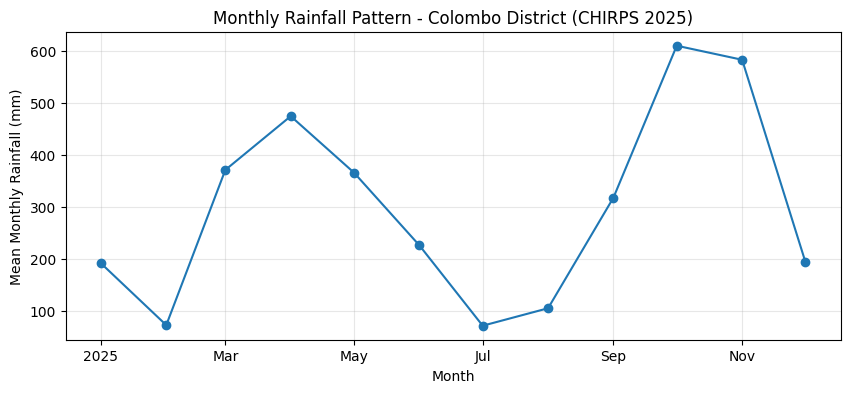

In [31]:
# Monthly spatial mean
monthly_spatial_mean = rainfall_cube.mean(dim=['latitude', 'longitude'])

plt.figure(figsize=(10, 4))
monthly_spatial_mean.plot(marker='o')
plt.xlabel('Month')
plt.ylabel('Mean Monthly Rainfall (mm)')
plt.title('Monthly Rainfall Pattern - Colombo District (CHIRPS 2025)')
plt.grid(True, alpha=0.3)
plt.show()

In [32]:
# Identify wettest and driest months
wettest_idx = int(monthly_spatial_mean.argmax())
driest_idx = int(monthly_spatial_mean.argmin())

print(f"Wettest month: {rainfall_cube.time.values[wettest_idx]} ({float(monthly_spatial_mean[wettest_idx]):.1f} mm)")
print(f"Driest month:  {rainfall_cube.time.values[driest_idx]} ({float(monthly_spatial_mean[driest_idx]):.1f} mm)")

Wettest month: 2025-10-01T00:00:00.000000000 (609.5 mm)
Driest month:  2025-07-01T00:00:00.000000000 (72.5 mm)


---

## 6. Raster-Vector Integration

Bidirectional integration as required.

In [33]:
# Save rasters for integration (FIXED)
# Use rioxarray to preserve exact georeferencing and avoid misalignment
import rioxarray

# 1. Save Rainfall
# Ensure it behaves like a proper GeoTIFF with CRS and Transform
if 'spatial_ref' not in max_monthly_rainfall.coords:
    max_monthly_rainfall = max_monthly_rainfall.rio.write_crs("EPSG:4326")

rainfall_path = OUTPUT_DIR / 'max_rainfall.tif'
max_monthly_rainfall.rio.to_raster(rainfall_path)
print(f"Saved Rainfall Correctly: {rainfall_path}")

# 2. Save Elevation
# Reconstruct DataArray to include filled values from 'elev_values'
elevation_processed = elevation.copy(data=elev_values)

if 'spatial_ref' not in elevation_processed.coords:
    elevation_processed = elevation_processed.rio.write_crs("EPSG:4326")

elevation_path = OUTPUT_DIR / 'elevation.tif'
elevation_processed.rio.to_raster(elevation_path)
print(f"Saved Elevation Correctly: {elevation_path}")


Saved Rainfall Correctly: ..\outputs\max_rainfall.tif
Saved Elevation Correctly: ..\outputs\elevation.tif


In [34]:
# RASTER to VECTOR: Zonal Statistics
admin_with_rainfall = integration.extract_zonal_statistics(
    admin_boundaries, rainfall_path,
    stats=['mean', 'max'], prefix='rainfall_'
)

admin_with_elev = integration.extract_zonal_statistics(
    admin_with_rainfall, elevation_path,
    stats=['mean', 'min'], prefix='elevation_'
)

print("RASTER to VECTOR: Zonal Statistics")
print(admin_with_elev[['ds_name', 'rainfall_mean', 'elevation_mean']])

RASTER to VECTOR: Zonal Statistics
             ds_name  rainfall_mean  elevation_mean
0       AluthMawatha     571.907959       11.565737
1        Bloemendhal     571.907959       12.489362
2        Gintupitiya     571.907959       13.600000
3       Lunupokurana     556.961995       13.740566
4          Mahawatte     549.489014       13.094595
5       Mattakkuliya     549.489014       11.541667
6             Modera     574.891479       10.469697
7          Grandpass     574.891479        9.772358
8    Masangasweediya     574.891479       11.333333
9          NewBazzar     574.891479       12.686275
10         Aluthkade     571.907959       14.871681
11       Kochchikade     571.907959       14.015306
12              Fort     571.907959       10.854962
13        Hunupitiya     573.399719       12.242424
14          Maradana     573.399719        8.467153
15         Suduwella     573.399719       13.670782
16          Weekanda     574.891479       11.293680
17       Maligakanda     574.

VECTOR to RASTER: Rasterized Building Density
   Shape: (25, 14)


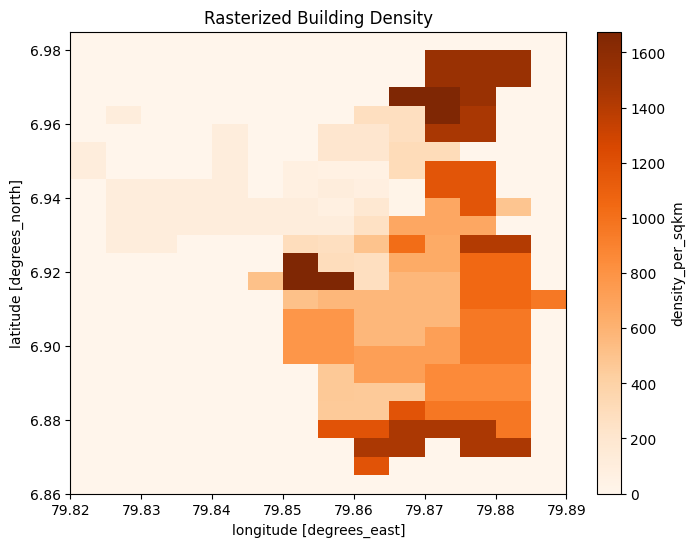

In [35]:
# VECTOR to RASTER: Rasterize building density
density_raster = integration.rasterize_vector(
    admin_with_density,
    value_column='density_per_sqkm',
    resolution=(-0.005, 0.005)
)

print("VECTOR to RASTER: Rasterized Building Density")
print(f"   Shape: {density_raster.shape}")

plt.figure(figsize=(8, 6))
density_raster.plot(cmap='Oranges')
plt.title('Rasterized Building Density')
plt.show()

### Calculate Vulnerability Index

In [36]:
# Combine all factors for vulnerability
result = admin_with_density.merge(
    admin_with_elev[['ds_id', 'rainfall_mean', 'rainfall_max', 'elevation_mean', 'elevation_min']],
    on='ds_id'
)

# Normalize factors
def normalize(series):
    return (series - series.min()) / (series.max() - series.min() + 1e-10)

rainfall_norm_v = normalize(result['rainfall_mean'])
density_norm_v = normalize(result['density_per_sqkm'])
elev_norm_v = normalize(result['elevation_mean'])

# Calculate vulnerability: V = 0.4*rainfall + 0.3*density + 0.3*(1-elevation)
result['vulnerability_score'] = (
    0.4 * rainfall_norm_v +
    0.3 * density_norm_v +
    0.3 * (1 - elev_norm_v)  # low elevation = high vulnerability
)

# Classify
result['vulnerability_class'] = pd.cut(
    result['vulnerability_score'],
    bins=[0, 0.3, 0.5, 0.7, 1.0],
    labels=['Low', 'Moderate', 'High', 'Extreme']
)

print("VULNERABILITY ASSESSMENT RESULTS")
print("=" * 80)
print(result[['ds_name', 'rainfall_mean', 'density_per_sqkm', 'elevation_mean', 'vulnerability_score', 'vulnerability_class']])
print("=" * 80)

VULNERABILITY ASSESSMENT RESULTS
             ds_name  rainfall_mean  density_per_sqkm  elevation_mean  \
0       AluthMawatha     571.907959        277.062940       11.565737   
1        Bloemendhal     571.907959        312.143267       12.489362   
2        Gintupitiya     571.907959        105.293117       13.600000   
3       Lunupokurana     556.961995        203.538421       13.740566   
4          Mahawatte     549.489014       1450.959188       13.094595   
5       Mattakkuliya     549.489014       1533.019446       11.541667   
6             Modera     574.891479       1675.671298       10.469697   
7          Grandpass     574.891479       1174.854118        9.772358   
8    Masangasweediya     574.891479         81.878528       11.333333   
9          NewBazzar     574.891479         25.366488       12.686275   
10         Aluthkade     571.907959        183.828008       14.871681   
11       Kochchikade     571.907959         78.463831       14.015306   
12              Fo

---

## 7. Visualization

Final maps and outputs.

In [37]:
# Add required columns for visualization
result['id'] = result['ds_id']

# Create interactive vulnerability map
vuln_map = visualization.create_vulnerability_map(
    result,
    value_column='vulnerability_score',
    title='Flood Vulnerability Score'
)

# Display
vuln_map

In [38]:
# Save interactive map
vuln_map.save(OUTPUT_DIR / 'vulnerability_map.html')
print(f"Saved: {OUTPUT_DIR / 'vulnerability_map.html'}")

Saved: ..\outputs\vulnerability_map.html


## 8. Advanced Flood Risk Analysis

In this section, we implement the full Multi-Criteria Decision Analysis (MCDA) workflow.


### 8.1 Hydrological Analysis

In [39]:
# === SCIENTIFIC MODULE: Advanced Flood Risk Modeling ===
# 1. Load Hydrological Data (Rivers/Canals)
water_path = RAW_DIR / 'landuse' / 'colombo_water_raw.json'
water_gdf = gpd.GeoDataFrame()

if water_path.exists():
    with open(water_path, 'r') as f:
        raw_water = json.load(f)
    
    # Parse raw JSON to GeoDataFrame (Simplified)
    water_feats = []
    for el in raw_water.get('elements', []):
        if el['type'] == 'way' and 'geometry' in el:
            coords = [(p['lon'], p['lat']) for p in el['geometry']]
            if len(coords) >= 2:
                water_feats.append({'geometry': LineString(coords), 'type': 'waterway'})
    
    if water_feats:
        water_gdf = gpd.GeoDataFrame(water_feats, crs='EPSG:4326')
        print(f"Loaded {len(water_gdf)} water features for hydrological analysis.")
    else:
        print("No water features parsed.")
else:
    print("Water data file not found. Skipping distance analysis.")


Water data file not found. Skipping distance analysis.


In [40]:
# 2. Calculate Raster Factors (Slope, Distance, Rainfall Anomalies)
import src.raster_analysis as ra

# Prepare inputs (Ensure same grid)
# Prepare inputs (Reproject to UTM Zone 44N for Metric accuracy)
# SRTM is in Degrees (WGS84), but Slope/Distance require Meters.
if hasattr(elevation, 'rio'):
    base_raster = elevation.rio.reproject("EPSG:32644")
    print(f"Reprojected DEM to UTM 44N (Resolution: {base_raster.rio.resolution()})")
else:
    base_raster = elevation # Fallback (Warning: Units may be wrong)
    print("Warning: Could not reproject DEM. Slope calculation may be inaccurate.")


# A. Slope Analysis
slope_map = ra.calculate_slope(base_raster)
slope_risk = ra.normalize_array(slope_map, method='minmax') 
# Invert: Low slope = High risk
slope_risk = 1.0 - slope_risk

# B. Distance to Water Analysis
if not water_gdf.empty:
    # Rasterize water features to create target mask
    water_mask = ra.mask_raster_with_vector(base_raster, water_gdf)
    # Get indices of water pixels (where not nan)
    target_indices = np.where(~np.isnan(water_mask.values))
    
    if len(target_indices[0]) > 0:
        dist_map = ra.calculate_euclidean_distance(base_raster.shape, target_indices, pixel_size=30)
        dist_da = xr.DataArray(dist_map, coords=base_raster.coords, dims=base_raster.dims)
        dist_risk = ra.normalize_array(dist_da, method='minmax')
        # Invert: Low distance = High risk
        dist_risk = 1.0 - dist_risk
    else:
        dist_risk = xr.zeros_like(base_raster)
else:
    dist_risk = xr.zeros_like(base_raster)

# C. Rainfall Anomalies (Z-Score)
# Use 2025 max rainfall as proxy for intensity
# Ensure we have a clipped rainfall cube
try:
    chirps_clipped
except NameError:
    if 'rainfall_cube' in globals():
        chirps_clipped = rainfall_cube
        print('Using rainfall_cube as chirps_clipped (already spatially clipped).')
    else:
        raise NameError("chirps_clipped is not defined and rainfall_cube is unavailable.")

rain_max = ra.calculate_annual_maximum(chirps_clipped).max(dim='year') if 'year' in chirps_clipped.dims else chirps_clipped.max(dim='time')
# Align Rainfall to DEM Grid (Reproject + Resample 5km -> 30m)
if hasattr(rain_max, 'rio'):
    try:
        rain_max = rain_max.rio.reproject_match(base_raster)
        print('Aligned Rainfall data to DEM grid.')
    except Exception as e:
        print(f'Warning: Rainfall alignment failed: {e}')

rain_risk = ra.normalize_array(rain_max, method='minmax')


CRSError: The EPSG code is unknown. PROJ: proj_create_from_database: C:\Program Files\PostgreSQL\18\share\contrib\postgis-3.6\proj\proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 5 is expected. It comes from another PROJ installation.

In [ ]:
# 3. AHP Weighted Overlay & Building Risk Sampling
import src.vector_analysis as va

# Define AHP Weights (Scenario: Urban Flash Flood)
# Distance to Water > Rainfall > Slope
weights = {
    'distance': 0.50,
    'rainfall': 0.30,
    'slope': 0.20
}

layers = {
    'distance': dist_risk,
    'rainfall': rain_risk,
    'slope': slope_risk
}

final_risk_map = ra.ahp_weighted_overlay(layers, weights)

# 4. Sample Risk to Buildings
print("Sampling risk scores for buildings (this may take a moment)...")
if not buildings_joined.empty:
    buildings_risk = va.sample_raster_values(buildings_joined, final_risk_map, column_name='risk_score')
    
    # Classify Risk
    buildings_risk = va.assign_risk_category(buildings_risk)
    
    # 5a. Full interactive map (large, may be heavy)
    map_path = OUTPUT_DIR / 'colombo_interactive_risk.html'
    va.generate_interactive_risk_map(buildings_risk, output_path=str(map_path))
    print(f"Full Interactive Risk Map saved to: {map_path} (may be large)")
    
    # 5b. Lightweight clustered map (recommended)
    map_path_light = OUTPUT_DIR / 'colombo_interactive_risk_light.html'
    va.generate_interactive_risk_map_clustered(
        buildings_risk,
        output_path=str(map_path_light),
        max_points_per_category=20000,
        include_low=False
    )
    print(f"Lightweight clustered map saved to: {map_path_light}")
    
    # 5c. Polygon map with true building geometry and tooltips (capped for size)
    map_path_poly = OUTPUT_DIR / 'colombo_interactive_risk_polygons.html'
    va.generate_interactive_risk_map_geojson(
        buildings_risk,
        output_path=str(map_path_poly),
        include_low=False,
        max_features=50000,
        simplify_tolerance=0.00005
    )
    print(f"Polygon map saved to: {map_path_poly}")
    
    # Display statistics
    print(buildings_risk['risk_category'].value_counts())
else:
    print("No buildings available for risk analysis.")


## 9. Results & Visualization

In [ ]:
# Create ranking chart
ranking_chart = visualization.create_vulnerability_ranking_chart(
    result,
    name_column='ds_name',
    value_column='vulnerability_score',
    top_n=10,
    title='Vulnerability Ranking - Colombo District'
)
ranking_chart.show()

In [ ]:
# Create static map for report
fig = visualization.create_static_map(
    result,
    value_column='vulnerability_score',
    title='Flood Vulnerability Assessment - Colombo District, Sri Lanka (CHIRPS 2025)',
    cmap='YlOrRd'
)

fig.savefig(OUTPUT_DIR / 'vulnerability_map.png', dpi=150, bbox_inches='tight')
print(f"Saved: {OUTPUT_DIR / 'vulnerability_map.png'}")

---

## Summary

This notebook demonstrated all required technical components using **real data**:

| Component | Implementation | Data Source |
|-----------|----------------|-------------|
| **NumPy Arrays** | Masking, normalization, statistics | CHIRPS rainfall |
| **PyTorch Tensors** | Gaussian convolution, performance comparison | Rainfall grid |
| **Vector Processing** | Spatial join, density, buffer (3+ ops) | OSM buildings |
| **Xarray Data Cubes** | Temporal slicing, aggregation | CHIRPS 2025 monthly |
| **Raster-Vector Integration** | Zonal stats (R-V), rasterization (V-R) | Both |

**Data Sources:**
- SRTM DEM from AWS Open Data
- CHIRPS 2025 monthly rainfall from UCSB
- Building footprints from OpenStreetMap

**Vulnerability Formula:**

$$V = 0.4 \times Rainfall_{norm} + 0.3 \times BuildingDensity_{norm} + 0.3 \times (1 - Elevation_{norm})$$